# Dependencies

## Download Python and pip

If Python or its package manager pip aren't installed, click the links below and follow the installation tutorials:
<br>
https://www.python.org/downloads/
<br>
https://pip.pypa.io/en/stable/installation/

## Importing libraries 

In [1674]:
%pip install pandas numpy matplotlib seaborn python-metar geopy scikit-learn xgboost optuna


Note: you may need to restart the kernel to use updated packages.


In [1675]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from geopy.distance import geodesic
from metar import Metar
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna
from datetime import datetime
from statistics import mode
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sns.set_theme()

# API requests

The code below is designed to extract data from the API provided by ITA (Instituto Tecnológico de Aeronáutica),
a prestigious college located in Brazil. The API offers comprehensive information about flights, including
meteorological data, radar snapshots, as well as details about the origin and destination of each flight.
This data can be used for a wide range of applications related to aviation. In this case, it's being used to create a machine learning model that predicts the Estimated Landing Time (ELDT) for each flight given its conditions.

In [1676]:
# path = './data'

# try:
#     os.mkdir(path)
# except FileExistsError:
#     print('Directory already exists.')

In [1677]:

# token = 'a779d04f85c4bf6cfa586d30aaec57c44e9b7173'

# initial_date = '2022-06-01'
# final_date = '2022-08-01'

# def load_csv(df, endpoint_name):
#     df.to_csv(f'data/{endpoint_name}.csv', index=False)
#     print(f'Dados de {endpoint_name} salvos em um arquivo CSV com sucesso!')
#     return df

# def api_request(endpoint, initial_date=initial_date, final_date=final_date, token=token):
#     url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + str(endpoint) + '?token=' + str(token) + '&idate=' + str(initial_date) + '&fdate=' + str(final_date)

#     res = requests.get(url)
    
#     if res.status_code == 200:
#         req = res.json()
#         df = pd.DataFrame(req)
#         return df
#     else:
#         print(f'Falha na solicitação de {endpoint}. Código de status:', res.status_code)

# endpoints_array = ['bimtra', 'esperas', 'metaf', 'metar', 'tc-prev', 'tc-real']

# for endpoint in endpoints_array:
#     df = api_request(endpoint)
#     load_csv(df, endpoint)

In [1678]:
# initial_dates_cat_62 = ['2022-06-01 00:00:00.000',
#                         '2022-06-15 00:00:00.000',
#                         '2022-06-25 00:00:00.000',
#                         '2022-07-05 00:00:00.000',
#                         '2022-07-10 00:00:00.000',
#                         '2022-07-20 00:00:00.000']

# final_dates_cat_62 = ['2022-06-15 00:00:00.000',
#                       '2022-06-25 00:00:00.000',
#                       '2022-07-05 00:00:00.000',
#                       '2022-07-10 00:00:00.000',
#                       '2022-07-20 00:00:00.000',
#                       '2022-08-01 00:00:00.000']

# for i, (initial_date, final_date) in enumerate(zip(initial_dates_cat_62, final_dates_cat_62)):
#     if i == 0:
#         cat_62_general = api_request('cat-62', initial_date, final_date)
#         print(f'{i+1} download out of 6 done!')
#     else:
#         cat_62_general = pd.concat([cat_62_general, api_request('cat-62', initial_date, final_date)])
#         print(f'{i+1} downloads out of 6 done!')


# load_csv(cat_62_general, 'cat-62')

## Loading data

In [1679]:
bimtra_df = pd.read_csv('data/bimtra.csv')
esperas_df = pd.read_csv('data/esperas.csv')
metaf_df = pd.read_csv('data/metaf.csv')
metar_df = pd.read_csv('data/metar.csv')
tc_prev_df = pd.read_csv('data/tc-prev.csv')
tc_real_df = pd.read_csv('data/tc-real.csv')
test_data = pd.read_csv('data/idsc_test.csv')
cat_62 = pd.read_csv('data/cat-62.csv')

# Exploratory Analysis

In [1680]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [1681]:
test_data.snapshot_radar.sample(1)

56    MULTIPOINT ((-0.8907326691456074 -0.5166844451...
Name: snapshot_radar, dtype: object

In [1682]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [1683]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [1684]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [1685]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')
print(f'cat_62: {cat_62.shape}')

bimtra_df: (48821, 5)
esperas_df: (17856, 3)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)
cat_62: (6102640, 6)


# Pre Processing

In [1686]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [1687]:
bimtra_df['solution'].describe()

count    48821.000000
mean      4691.582372
std       2534.483202
min     -83541.000000
25%       2940.000000
50%       4112.000000
75%       5457.000000
max      19408.000000
Name: solution, dtype: float64

In [1688]:
bimtra_df.sort_values(by='solution' ,ascending=True).head(5)

,flightid,origem,destino,dt_dep,dt_arr,solution
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541
1621,a8682cab7acc8720963b1bcf100e8e14,SBFL,SBSP,1654300317000,1654217151000,-83166
43358,8a053ceddd5cd22a111236b4975b990b,SBSP,SBCF,1658876193000,1658793794000,-82399
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133
43121,8bbeac6a115b8eed176d85126e5c4b98,SBBR,SBSP,1658876568000,1658795244000,-81324


In [1689]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= 2000) & (bimtra_df['solution'] <= q3 + 1.5*iqr + 3000)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [1690]:
bimtra_df['solution'].describe()

count    48502.000000
mean      4691.116201
std       2254.123029
min       2002.000000
25%       2945.000000
50%       4114.000000
75%       5444.000000
max      12223.000000
Name: solution, dtype: float64

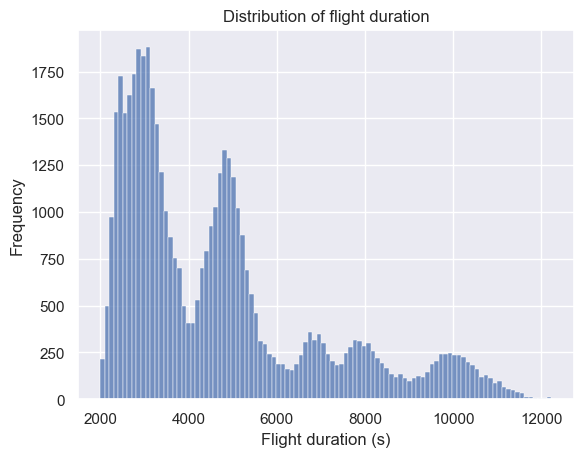

In [1691]:
sns.histplot(bimtra_df['solution'], bins=100)
plt.title('Distribution of flight duration')
plt.xlabel('Flight duration (s)')
plt.ylabel('Frequency')
plt.show()

In [1692]:
bimtra_df.query('solution < 0')

,flightid,origem,destino,dt_dep,dt_arr,solution


In [1693]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [1694]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00


In [1695]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(6167, 4)

In [1696]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [1697]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [1698]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (48502, 7)
esperas_df: (17856, 5)
metaf_df: (5384, 3)
metar_df: (18358, 3)
tc_prev_df: (17856, 3)
tc_real_df: (6167, 4)


In [1699]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [1700]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [1701]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [1702]:
train_data.sort_values(by='solution' ,ascending=False).head(20)

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
31817,c6ee21c9f340d972df91f762a3b92370,SBSV,SBPA,2022-07-08 17:57:27,2022-07-08 21:21:10,12223,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,0,SBPA,2022-07-08 17:00:00,NaN,NaN,NaN,NaT
9812,94cba9a52482732b50b18a3969828fec,SBSV,SBPA,2022-06-12 18:42:47,2022-06-12 22:06:26,12219,2022-06-12 18:00:00,0,SBPA,2022-06-12 18:00:00,1,SBPA,2022-06-12 18:00:00,NaN,NaN,NaN,NaT
51425,582f3a20fb7ebb2a741fa213973379b4,SBSV,SBPA,2022-07-29 17:57:46,2022-07-29 21:21:21,12215,2022-07-29 17:00:00,0,SBPA,2022-07-29 17:00:00,1,SBPA,2022-07-29 17:00:00,NaN,NaN,NaN,NaT
52209,02314e4281634ee3840ed7ef79b8f685,SBSV,SBPA,2022-07-30 18:06:32,2022-07-30 21:29:49,12197,2022-07-30 18:00:00,0,SBPA,2022-07-30 18:00:00,1,SBPA,2022-07-30 18:00:00,NaN,NaN,NaN,NaT
25169,72ec4a1e747c200085d7b78ce74d5448,SBSV,SBPA,2022-06-30 17:58:59,2022-06-30 21:22:14,12195,2022-06-30 17:00:00,0,SBPA,2022-06-30 17:00:00,1,SBPA,2022-06-30 17:00:00,29,11,SBPA,2022-06-30 17:17:00
49469,00d75cc32867fe9fc6520492b8224e4d,SBSV,SBPA,2022-07-27 18:12:22,2022-07-27 21:35:22,12180,2022-07-27 18:00:00,0,SBPA,2022-07-27 18:00:00,1,SBPA,2022-07-27 18:00:00,NaN,NaN,NaN,NaT
5959,a6e0a7165193a34dad4237e650af75ac,SBSV,SBPA,2022-06-08 18:02:31,2022-06-08 21:25:17,12166,2022-06-08 18:00:00,0,SBPA,2022-06-08 18:00:00,1,SBPA,2022-06-08 18:00:00,NaN,NaN,NaN,NaT
34154,d3a2974604fd4aac214ec3af25a9c9ab,SBRF,SBSP,2022-07-10 11:31:59,2022-07-10 14:54:41,12162,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,0,SBSP,2022-07-10 11:00:00,NaN,NaN,NaN,NaT
44520,fca3feeced4fd2f5f52aa83bef0369dd,SBRF,SBSP,2022-07-21 09:24:42,2022-07-21 12:47:14,12152,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,0,SBSP,2022-07-21 09:00:00,NaN,NaN,NaN,NaT
34160,6a652367d0fb5e46a983c8183aebdadb,SBRF,SBSP,2022-07-10 09:24:27,2022-07-10 12:46:51,12144,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,0,SBSP,2022-07-10 09:00:00,35L,17L,SBSP,2022-07-10 09:10:43


In [1703]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
31066,86fb5b97275b9b4eb05cc52053380361,SBSP,SBRJ,2022-07-07 14:53:36,2022-07-07 15:35:43,2527,2022-07-07 14:00:00,0,SBRJ,2022-07-07 14:00:00,1,SBRJ,2022-07-07 14:00:00,NaN,NaN,NaN,NaT
10353,ce526d02d96b6a51eea570e9b272a071,SBSP,SBCT,2022-06-13 00:02:17,2022-06-13 00:43:30,2473,2022-06-13 00:00:00,0,SBCT,2022-06-13 00:00:00,1,SBCT,2022-06-13 00:00:00,NaN,NaN,NaN,NaT
18064,e831cd17a5510341965c886bc5cd87d5,SBGR,SBSV,2022-06-22 15:17:30,2022-06-22 17:19:55,7345,2022-06-22 15:00:00,0,SBSV,2022-06-22 15:00:00,1,SBSV,2022-06-22 15:00:00,10,17,SBSV,2022-06-22 15:17:42
11437,17c8ca10e2b4023660c7996b11e2cb4f,SBFL,SBKP,2022-06-14 23:01:44,2022-06-14 23:56:43,3299,2022-06-14 23:00:00,1,SBKP,2022-06-14 23:00:00,0,SBKP,2022-06-14 23:00:00,NaN,NaN,NaN,NaT
39929,39c787ed700cbd6078438e58e52eb184,SBKP,SBGL,2022-07-17 21:00:17,2022-07-17 21:42:20,2523,2022-07-17 21:00:00,0,SBGL,2022-07-17 21:00:00,0,SBGL,2022-07-17 21:00:00,NaN,NaN,NaN,NaT
21450,30052c1b5b78075ec80552bd48857008,SBSP,SBSV,2022-06-26 13:59:32,2022-06-26 15:54:12,6880,2022-06-26 13:00:00,0,SBSV,2022-06-26 13:00:00,0,SBSV,2022-06-26 13:00:00,17,10,SBSV,2022-06-26 13:42:32
12351,1a4da38c8000ab495020b5f438b65740,SBKP,SBBR,2022-06-15 19:44:14,2022-06-15 21:04:31,4817,2022-06-15 19:00:00,0,SBBR,2022-06-15 19:00:00,1,SBBR,2022-06-15 19:00:00,11R,17,SBBR,2022-06-15 19:18:07
40179,98ee833cb0514aa3d197672e183b3d6c,SBCT,SBBR,2022-07-17 09:07:37,2022-07-17 10:50:08,6151,2022-07-17 09:00:00,0,SBBR,2022-07-17 09:00:00,1,SBBR,2022-07-17 09:00:00,NaN,NaN,NaN,NaT
34586,7bc6593e671d8c98cb4170533116ae80,SBRJ,SBCT,2022-07-11 20:17:52,2022-07-11 21:28:46,4254,2022-07-11 20:00:00,0,SBCT,2022-07-11 20:00:00,1,SBCT,2022-07-11 20:00:00,NaN,NaN,NaN,NaT
26817,0f94ac3cb2a0f0c64da475a4f7cbf0b1,SBGR,SBRJ,2022-07-02 15:48:37,2022-07-02 16:24:54,2177,2022-07-02 15:00:00,0,SBRJ,2022-07-02 15:00:00,1,SBRJ,2022-07-02 15:00:00,NaN,NaN,NaN,NaT


(54767, 17)

In [1704]:
train_data.isna().sum() 

flightid                0
origem                  0
destino                 0
dt_dep                  0
dt_arr                  0
solution                0
hora_ref                0
esperas                 0
aero_esperas            0
hora_esperas            0
troca                   0
aero_tcp                0
hora_tcp                0
nova_cabeceira      37301
antiga_cabeceira    37301
aero_tcr            37301
hora_tcr            37301
dtype: int64

In [1705]:
train_data.shape

(54767, 17)

In [1706]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [1707]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [1708]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [1709]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,0,SBCF,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,NaN,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,2023-05-19 09:00:00.000,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,2023-05-22 12:00:00.000,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,2023-05-29 17:00:00.000,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,2023-05-25 23:00:00.000,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


## METAR and METAF decoding

In [1710]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [1711]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [1712]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
                            ...                        
95    METAF SBGR 192300Z  11006KT 9000       FEW019 ...
96    METAF SBKP 312000Z  23006KT 9999       OVC022 ...
97    METAF SBRJ 201600Z  10003KT 9999       FEW033 ...
98    METAF SBSP 311200Z 07006KT 6000  - RA  OVC026 ...
99      METAF SBCT 201400Z 01002KT CAVOK 19/08 Q1020=\n
Name: metaf, Length: 100, dtype: object

In [1713]:
test_data.metaf = test_data.metaf.fillna('')

In [1714]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [1715]:
metaf_df.shape

(5384, 3)

In [1716]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [1717]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [1718]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
1398,2022-06-03 20:00:00,METAR SBGR 032000Z 16007KT 8000 OVC016 ...,SBGR,17.0,13.0,160.0,8000.0,7.0,1020.0
5065,2022-07-19 17:00:00,METAR SBSP 191700Z 31006KT CAVOK 27/06 Q1021,SBSP,27.0,6.0,310.0,10000.0,6.0,1021.0
3753,2022-07-21 03:00:00,METAR SBKP 210300Z 10008KT 4000 BR BKN033...,SBKP,17.0,15.0,100.0,4000.0,8.0,1017.0
4722,2022-07-05 10:00:00,METAR SBSP 051000Z 33005KT CAVOK 15/07 Q1020,SBSP,15.0,7.0,330.0,10000.0,5.0,1020.0
1185,2022-07-26 07:00:00,METAR SBGL 260700Z 14003KT CAVOK 20/17 Q1020,SBGL,20.0,17.0,140.0,10000.0,3.0,1020.0


In [1719]:
metaf_df.shape

(5384, 9)

In [1720]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [1721]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(18358, 18)

In [1722]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [1723]:
train_data.shape

(54767, 17)

In [1724]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [1725]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

## Label Encoding

In [1726]:
le = LabelEncoder()

cat_columns = ['aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,aero_esperas,aero_tcp,aero_tcr
0,SBRJ,SBRJ,NaN
1,SBRJ,SBRJ,NaN
2,SBRJ,SBRJ,NaN
3,SBCF,SBCF,NaN
4,SBFL,SBFL,NaN


In [1727]:
train_data[cat_columns].head()

,aero_esperas,aero_tcp,aero_tcr
0,9,9,12
1,9,9,12
2,9,9,12
3,1,1,12
4,3,3,12


## Feature Engineering

In [1728]:
train_data['route_cat'], test_data['route_cat'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
le.fit(train_data['route_cat'])
train_data['route']= le.transform(train_data['route_cat'])
test_data['route']= le.transform(test_data['route_cat'])

display(train_data['route'].head())


0    51
1    46
2     8
3    16
4    13
Name: route, dtype: int64

In [1729]:
train_data[['origem', 'destino']], test_data[['origem', 'destino']] = train_data[['origem', 'destino']].apply(le.fit_transform), test_data[['origem', 'destino']].apply(le.transform)

In [1730]:
train_data['route'].unique()

array([51, 46,  8, 16, 13, 28, 19, 55, 44, 54, 49, 17,  5,  4,  0,  3, 35,
        7, 45, 58, 57,  9, 60, 20, 26, 47, 15, 59, 34, 61, 10, 18,  1, 37,
       33,  6, 38, 62, 25, 50, 21, 12, 53, 32, 31, 24,  2, 27, 22, 40, 56,
       42, 52, 14, 43, 39, 48, 41, 29, 11, 36, 30, 23])

In [1731]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2022-06-01 01:26:00,2463,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBKP-SBRJ,51
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2022-06-01 01:32:53,2152,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBGR-SBRJ,46
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,0,9,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,23.0,20.0,170.0,10000.0,6.0,1015.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR-SBRJ,8
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2022-06-01 01:41:41,2581,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,0,1,2022-06-01 00:00:00,NaN,NaN,12,NaT,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018,21.0,14.0,120.0,10000.0,6.0,1018.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBKP,16
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,0,3,2022-06-01 01:00:00,NaN,NaN,12,NaT,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,13.0,7.0,150.0,10000.0,5.0,1021.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBCF-SBFL,13


In [1732]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,11,NaN,,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,11,NaN,12,28.0,21.0,120.0,10000.0,9.0,1019.0,None,None,None,None,None,None,0,0,0,0,0,SBKP-SBSV,53
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,9,2023-05-19 09:00:00.000,METAR SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,9,NaN,12,19.0,17.0,20.0,10000.0,4.0,1019.0,17.0,12.0,330.0,10000.0,4.0,1020.0,0,0,0,0,0,SBFL-SBRJ,34
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,5,2023-05-22 12:00:00.000,METAR SBGR 221200Z 04003KT CAVOK 19/09 Q1021,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022,SBGR,2023-05-22 12:00:00.000,0,5,NaN,12,13.0,12.0,70.0,10000.0,6.0,1022.0,19.0,9.0,40.0,10000.0,3.0,1021.0,0,0,0,0,0,SBCF-SBGR,15
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,10,2023-05-29 17:00:00.000,METAR SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,10,NaN,12,19.0,14.0,120.0,10000.0,10.0,1023.0,18.0,14.0,150.0,10000.0,10.0,1019.0,0,0,0,0,0,SBFL-SBSP,35
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,6,2023-05-25 23:00:00.000,METAR SBKP 252300Z 08008KT CAVOK 21/12 Q1019,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020,SBKP,2023-05-25 23:00:00.000,0,6,NaN,12,23.0,13.0,90.0,10000.0,4.0,1020.0,21.0,12.0,80.0,10000.0,8.0,1019.0,0,0,0,0,0,SBCF-SBKP,16


In [1733]:
np.count_nonzero(train_data.route.unique())

62

In [1734]:
train_data['solution'].describe()

count    54767.000000
mean      4733.140303
std       2221.298059
min       2002.000000
25%       2987.000000
50%       4236.000000
75%       5653.500000
max      12223.000000
Name: solution, dtype: float64

In [1735]:
train_data.shape

(54767, 35)

In [1736]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [1737]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [1738]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [1739]:
def categorize_wind_direction(degrees):
    if (337 <= degrees <= 360) or (0 <= degrees < 23):
        return "N"
    elif 23 <= degrees < 68:
        return "NE"
    elif 68 <= degrees < 113:
        return "E"
    elif 113 <= degrees < 158:
        return "SE"
    elif 158 <= degrees < 203:
        return "S"
    elif 203 <= degrees < 248:
        return "SW"
    elif 248 <= degrees < 293:
        return "W"
    elif 293 <= degrees < 337:
        return "NW"
    else:
        return None

In [1740]:
train_data['wind_direction_real'] , train_data['wind_direction_prev'] = train_data['wind_direction_real'].apply(categorize_wind_direction), train_data['wind_direction_prev'].apply(categorize_wind_direction)
test_data['wind_direction_real'] , test_data['wind_direction_prev'] = test_data['wind_direction_real'].apply(categorize_wind_direction), test_data['wind_direction_prev'].apply(categorize_wind_direction)

train_data['wind_direction_real'].unique()

array(['S', 'SE', 'E', 'N', 'W', 'NE', 'SW', 'NW'], dtype=object)

In [1741]:
le.fit(train_data['wind_direction_real'])
train_data['wind_direction_real'], train_data['wind_direction_prev'] = le.transform(train_data['wind_direction_real']), le.transform(train_data['wind_direction_prev'])
test_data['wind_direction_real'], test_data['wind_direction_prev'] = le.transform(test_data['wind_direction_real']), le.transform(test_data['wind_direction_prev'])

In [1742]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [1743]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [1744]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54767 entries, 0 to 54766
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flightid             54767 non-null  object 
 1   origem               54767 non-null  int64  
 2   destino              54767 non-null  int64  
 3   dt_dep               54767 non-null  int32  
 4   solution             54767 non-null  int64  
 5   esperas              54767 non-null  int64  
 6   aero_esperas         54767 non-null  int64  
 7   troca                54767 non-null  int64  
 8   aero_tcp             54767 non-null  int64  
 9   aero_tcr             54767 non-null  int64  
 10  temperature_real     54767 non-null  float64
 11  dew_point_real       54767 non-null  float64
 12  wind_direction_real  54767 non-null  int64  
 13  visibility_real      54767 non-null  float64
 14  wind_speed_real      54767 non-null  float64
 15  pressure_real        54767 non-null 

## Cat-62

### Distance

In [1745]:
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

In [1746]:
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')



result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()

,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-0.277090,-0.835903,-0.409024,-0.811327,14.842761
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-0.400255,-0.753191,-0.277745,-0.840381,16.664585
2,0003d070d3cddc8a27e29b0d7ec5d22e,-0.400288,-0.753024,-0.412329,-0.814326,6.952673
3,0004cef34a36fdefb955840edcd85920,-0.411467,-0.814176,-0.400477,-0.753041,6.912992
4,0006b847a46b199088d53b7e9b1d92b0,-0.225074,-0.667812,-0.408984,-0.811026,25.839791


In [1747]:
import pandas as pd
from geopy.distance import geodesic
import math

# Assuming you have a DataFrame called df with your dataset
# Replace 'df' with your actual DataFrame

# Group the data by flightid and find the rows with the lowest and highest dt_radar values for each flight
lowest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmin()
highest_dt_radar_rows = cat_62.groupby('flightid')['dt_radar'].idxmax()

# Extract the lat and lon values for the lowest and highest dt_radar rows
lowest_lat_lon = cat_62.loc[lowest_dt_radar_rows, ['flightid', 'lat', 'lon']]
highest_lat_lon = cat_62.loc[highest_dt_radar_rows, ['flightid', 'lat', 'lon']]

# Convert radians to degrees for latitudes and longitudes
lowest_lat_lon['lat'] = lowest_lat_lon['lat'].apply(lambda x: math.degrees(x))
lowest_lat_lon['lon'] = lowest_lat_lon['lon'].apply(lambda x: math.degrees(x))
highest_lat_lon['lat'] = highest_lat_lon['lat'].apply(lambda x: math.degrees(x))
highest_lat_lon['lon'] = highest_lat_lon['lon'].apply(lambda x: math.degrees(x))

# Rename the columns
lowest_lat_lon = lowest_lat_lon.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})
highest_lat_lon = highest_lat_lon.rename(columns={'lat': 'final_lat', 'lon': 'final_lon'})

# Merge the two DataFrames based on flightid
result_df = pd.merge(lowest_lat_lon, highest_lat_lon, on='flightid')

# Calculate the distance between start and final coordinates using Geopy
result_df['distance'] = result_df.apply(
    lambda row: geodesic((row['start_lat'], row['start_lon']), (row['final_lat'], row['final_lon'])).kilometers,
    axis=1
)

# Display the resulting DataFrame
result_df.head()


,flightid,start_lat,start_lon,final_lat,final_lon,distance
0,000227eb6537e848e73cddb2e16c1cfa,-15.876090,-47.893716,-23.435326,-46.485612,849.721124
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,-22.932935,-43.154675,-15.913607,-48.150257,937.304044
2,0003d070d3cddc8a27e29b0d7ec5d22e,-22.934798,-43.145079,-23.624697,-46.657456,367.372408
3,0004cef34a36fdefb955840edcd85920,-23.575327,-46.648857,-22.945616,-43.146086,365.130565
4,0006b847a46b199088d53b7e9b1d92b0,-12.895815,-38.262813,-23.433042,-46.468382,1452.970535


In [1748]:
display(result_df.shape)
display(train_data.shape)

(45911, 6)

(54767, 24)

In [1749]:
result_df = result_df[result_df['distance'] > 0]

In [1750]:
result_df['distance'].describe()

count    45885.000000
mean       825.193325
std        527.104720
min          0.005948
25%        371.940500
50%        676.519979
75%        961.140610
max       3371.121669
Name: distance, dtype: float64

### Speed

In [1751]:
cat_62.head()

,flightid,lat,lon,flightlevel,speed,dt_radar
0,b6f0f8308bec35b30533f84c72dac496,-0.505849,-0.884547,80.0,122.0,1654976586000
1,b6f0f8308bec35b30533f84c72dac496,-0.511227,-0.885964,80.0,114.0,1654977185000
2,b6f0f8308bec35b30533f84c72dac496,-0.512399,-0.886286,80.0,122.0,1654977306000
3,b6f0f8308bec35b30533f84c72dac496,-0.514589,-0.886866,77.0,117.0,1654977544000
4,b6f0f8308bec35b30533f84c72dac496,-0.497432,-0.882033,80.0,117.0,1654975686000


In [1752]:
speed_df = cat_62.groupby('flightid')['speed'].mean().reset_index()

In [1753]:
speed_df.head()

,flightid,speed
0,000227eb6537e848e73cddb2e16c1cfa,374.767442
1,0003c4e7b0f7bb0c921a13aa1f13a0f8,384.700000
2,0003d070d3cddc8a27e29b0d7ec5d22e,278.821782
3,0004cef34a36fdefb955840edcd85920,305.333333
4,0006b847a46b199088d53b7e9b1d92b0,361.530702


### Merging

In [1754]:
train_data = pd.merge(train_data, result_df, on='flightid', how='inner')

In [1755]:
train_data = pd.merge(train_data, speed_df, on='flightid', how='inner')

In [1756]:
train_data.head(5)

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,402.893743,363.492754
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,336.874290,324.048387
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.682989,395.265152
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,5,10000.0,6.0,1018.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.097133,415.213333
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,5,10000.0,5.0,1021.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1003.534884,357.903030


In [1757]:
train_data.shape

(51921, 30)

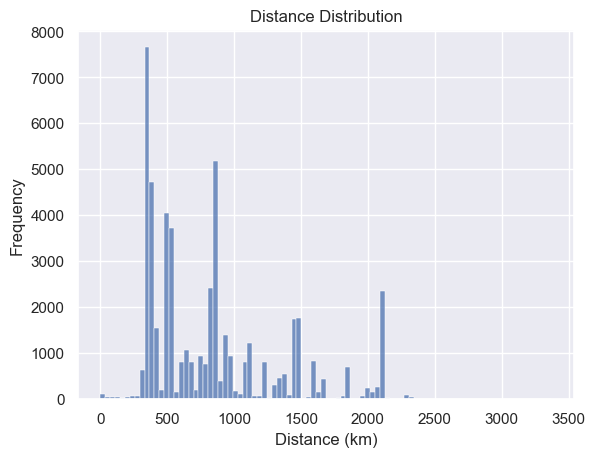

In [1758]:
sns.histplot(train_data['distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.show()

In [1759]:
train_data['median_distance'] = train_data.groupby('route')['distance'].transform('median')
route_median_mapping = train_data.set_index('route')['median_distance'].to_dict()
test_data['distance'] = test_data['route'].map(route_median_mapping)
train_data['distance'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,0,11,0,11,12,28.0,21.0,5,10000.0,9.0,1019.0,19.62963,10.530864,5,9181.481481,5.123457,1019.592593,0,0,0,0,0,SBKP-SBSV,53,1455.122485
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,0,9,0,9,12,19.0,17.0,1,10000.0,4.0,1019.0,17.00000,12.000000,3,10000.000000,4.000000,1020.000000,0,0,0,0,0,SBFL-SBRJ,34,755.358288
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,0,5,0,5,12,13.0,12.0,0,10000.0,6.0,1022.0,19.00000,9.000000,2,10000.000000,3.000000,1021.000000,0,0,0,0,0,SBCF-SBGR,15,490.689288
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2,10,0,10,12,19.0,14.0,5,10000.0,10.0,1023.0,18.00000,14.000000,5,10000.000000,10.000000,1019.000000,0,0,0,0,0,SBFL-SBSP,35,485.873175
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,0,6,0,6,12,23.0,13.0,0,10000.0,4.0,1020.0,21.00000,12.000000,0,10000.000000,8.000000,1019.000000,0,0,0,0,0,SBCF-SBKP,16,497.150203


In [1760]:
train_data.head()

,flightid,origem,destino,dt_dep,solution,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,route_cat,route,start_lat,start_lon,final_lat,final_lon,distance,speed,median_distance
0,fcb2bf90345705318213ae1307c0f901,6,9,0,2463,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBKP-SBRJ,51,-23.049409,-47.089329,-22.918608,-43.162407,408.105110,363.492754,408.105110
1,c7c5c10716335b048f86d8c52fcba3f2,5,9,0,2152,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBGR-SBRJ,46,-23.408319,-46.407657,-22.912327,-43.161847,344.342100,324.048387,344.342100
2,3162de7203a972f071d5a48e8f0f4828,0,9,0,4613,0,9,0,9,12,23.0,20.0,4,10000.0,6.0,1015.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBBR-SBRJ,8,-15.878665,-47.894573,-22.913170,-43.160765,923.832189,395.265152,923.832189
3,8fcd243e9b9eebbe62ab145ce04b6ab5,6,1,0,2581,0,1,0,1,12,21.0,14.0,5,10000.0,6.0,1018.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBCF-SBKP,16,-23.017542,-47.118901,-19.636025,-43.966203,497.150203,415.213333,497.150203
4,504a62621cd231d6ab67e674ce538cd3,1,3,1,5547,0,3,0,3,12,13.0,7.0,5,10000.0,5.0,1021.0,19.411903,10.617209,6,8315.373126,5.875,1017.953257,SBCF-SBFL,13,-19.654805,-43.948362,-27.674720,-48.532466,1004.346329,357.903030,1004.346329


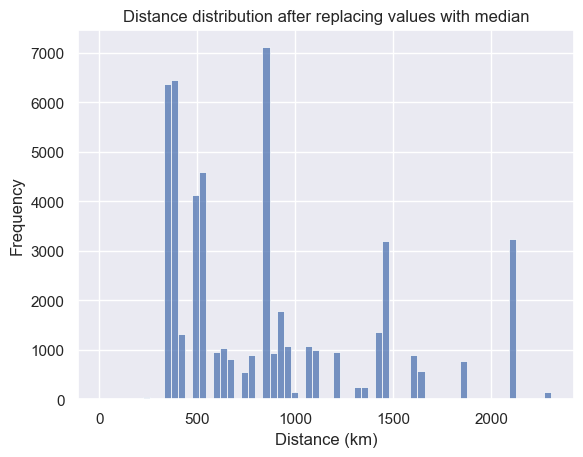

In [1761]:
sns.histplot(train_data['distance'])
plt.title('Distance distribution after replacing values with median')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [1762]:
grouped_counts = train_data.groupby('route_cat')['distance'].value_counts().reset_index(name='count')

# Sort the DataFrame by 'distance'
sorted_counts = grouped_counts.sort_values(by=['distance', 'count'], ascending=[True, False])

print(sorted_counts)

    route_cat     distance  count
43  SBGR-SBGR     5.198789      6
48  SBKP-SBKP     5.768742      1
11  SBCF-SBCF    34.098083      4
41  SBGL-SBRJ    63.906649      1
52  SBKP-SBSP    77.920520      2
..        ...          ...    ...
36  SBFL-SBSV  1953.663122      5
45  SBGR-SBRF  2090.437998   1480
50  SBKP-SBRF  2100.150113    513
58  SBRF-SBSP  2121.544169   1247
56  SBPA-SBSV  2305.738086    136

[63 rows x 3 columns]


In [1763]:
routes_to_remove = ['SBGR-SBGR', 'SBKP-SBKP', 'SBCF-SBCF']

train_data = train_data[~train_data['route_cat'].isin(routes_to_remove)]
sorted_counts = sorted_counts[~sorted_counts['route_cat'].isin(routes_to_remove)]

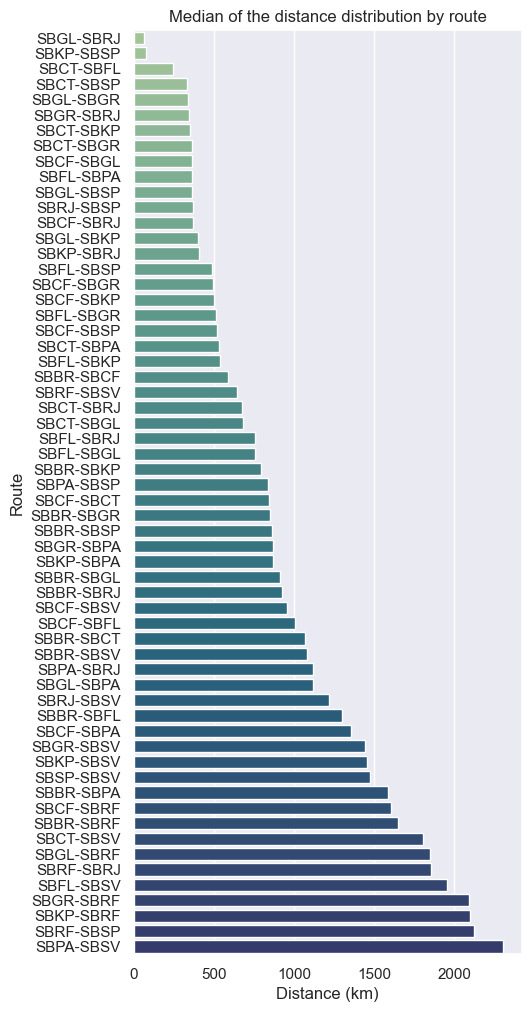

In [1764]:
plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
sns.barplot(x='distance', y='route_cat', data=sorted_counts, palette='crest')
plt.ylabel('Route')
plt.xlabel('Distance (km)')
plt.title('Median of the distance distribution by route')
plt.show()

In [1765]:
train_data['mean_speed'] = train_data.groupby('route')['speed'].transform('mean')
route_median_mapping = train_data.set_index('route')['mean_speed'].to_dict()
test_data['speed'] = test_data['route'].map(route_median_mapping)
train_data['speed'] = train_data['route'].map(route_median_mapping)
test_data.head()

,flightid,origem,destino,dt_dep,esperas,aero_esperas,troca,aero_tcp,aero_tcr,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,dt_arr,nova_cabeceira,antiga_cabeceira,hora_x,hora_y,route_cat,route,distance,speed
0,7945735584a3297121c4f5ae0de8ecd1,6,11,11,0,11,0,11,12,28.0,21.0,5,10000.0,9.0,1019.0,19.62963,10.530864,5,9181.481481,5.123457,1019.592593,0,0,0,0,0,SBKP-SBSV,53,1455.122485,416.907654
1,85cb958e8b9d583575cd9cb93e389226,3,9,8,0,9,0,9,12,19.0,17.0,1,10000.0,4.0,1019.0,17.00000,12.000000,3,10000.000000,4.000000,1020.000000,0,0,0,0,0,SBFL-SBRJ,34,755.358288,356.639914
2,2d4e8cd3947525a12ff16af520beefb9,1,5,11,0,5,0,5,12,13.0,12.0,0,10000.0,6.0,1022.0,19.00000,9.000000,2,10000.000000,3.000000,1021.000000,0,0,0,0,0,SBCF-SBGR,15,490.689288,354.528109
3,24cf317a1494a016a018d9f5cd183639,3,10,16,2,10,0,10,12,19.0,14.0,5,10000.0,10.0,1023.0,18.00000,14.000000,5,10000.000000,10.000000,1019.000000,0,0,0,0,0,SBFL-SBSP,35,485.873175,332.013453
4,370babaf32dc82a6a64bf5b71a3434ed,1,6,22,0,6,0,6,12,23.0,13.0,0,10000.0,4.0,1020.0,21.00000,12.000000,0,10000.000000,8.000000,1019.000000,0,0,0,0,0,SBCF-SBKP,16,497.150203,349.446888


In [1766]:
# plt.figure(figsize=(5, .2*len(sorted_counts['route_cat'].unique())))
# sns.barplot(x='mean_speed', y='route_cat', data=sorted_counts, palette='crest')
# plt.ylabel('Route')
# plt.xlabel('Speed (km/h)')
# plt.title('Median of the distance distribution by route')
# plt.show()

# Modeling

In [1767]:
train_data.shape

(51910, 32)

In [1768]:
features = train_data.columns
features = features.drop(['flightid', 'solution', 'start_lat', 'start_lon', 'final_lat', 'final_lon', 'median_distance', 'mean_speed','route_cat'])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

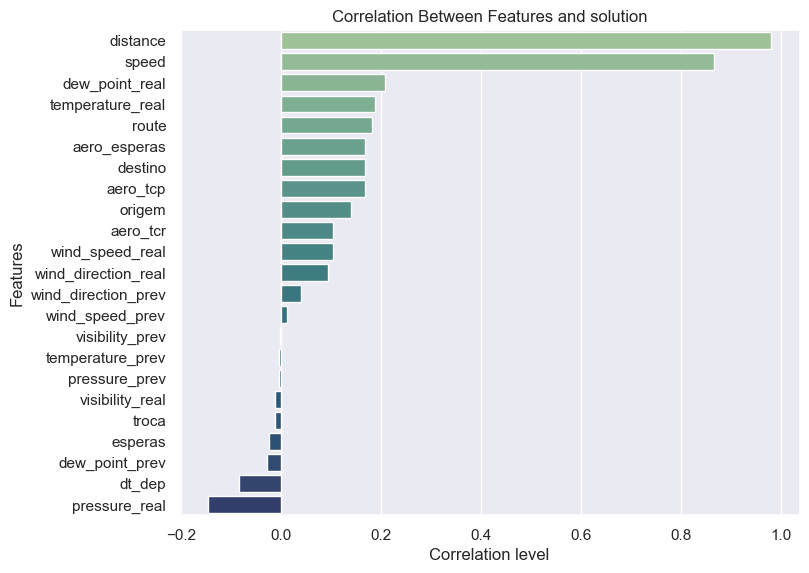

In [1769]:

correlation = pd.DataFrame()
correlation['correlation'] = [train_data[column].corr(train_data['solution'], method='pearson') for column in features if train_data[column].corr(train_data['solution'], method='pearson') != 0]
correlation['features'] = [features for features in features if train_data[features].corr(train_data['solution'], method='pearson') != 0]

correlation = correlation.sort_values(by='correlation', ascending=False)
plt.figure(figsize=(8, .3*len(correlation.correlation.unique())))
plt.title('Correlation Between Features and solution')
sns.barplot(data=correlation, x='correlation', y='features', orient='h', palette='crest')
plt.xlabel('Correlation level')
plt.ylabel('Features')
plt.show()

In [1770]:
train_data.to_csv('data/train_data.csv', index=False)

In [1771]:
# def objective(trial):
#     params = {
#         'objective': 'reg:squarederror',
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
#         'max_depth': trial.suggest_int('max_depth', 1, 20),
#         'alpha': trial.suggest_float('alpha', 0, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 1, 1000)
#     }

#     model = xgb.XGBRegressor(**params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_pred = np.round_(y_pred)
#     mse = mean_squared_error(y_test, y_pred)

#     return mse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_mse = study.best_value


# print(f'Best Hyperparameters: {best_params}')
# print(f'Best MSE: {best_mse}')

In [1802]:
model_ideal = xgb.XGBRegressor(**best_params)
model_ideal.fit(X_train, y_train)
y_pred_ideal = model_ideal.predict(X_test)
y_pred_ideal = np.round_(y_pred_ideal)
print(f'\nXGBoost Regressor MSE: {mean_squared_error(y_test, y_pred_ideal)}')


XGBoost Regressor MSE: 73876.14525139665


The model tested above utilized Optuna for hyperparameter optimization and employed a train-test split for validation, leading to its superior performance. On the contrary, the most successful submission was achieved using a model that used hand-tested parameters rather than the default or the optimized ones. This performance difference may be explained by the potential dissimilarities between the training data and the submission data. The training set could contain more instances with extreme variable values compared to the provided test set. This can lead to less accurate predictions when the model is fine-tuned exclusively for the training data.

In [1803]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)
print(f'\nXGBoost Regressor MSE: {mean_squared_error(y_test, y_pred)}')

#77884.43064920054: 20,346


XGBoost Regressor MSE: 77884.43064920054


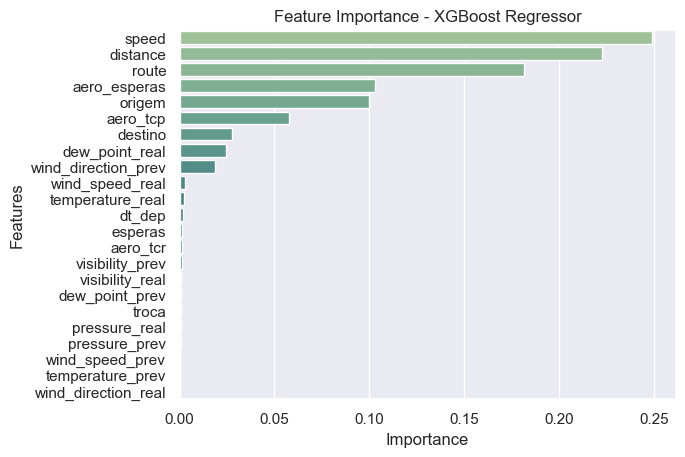

In [1804]:
sns.barplot(data=pd.DataFrame({'features':features, 'importance':model.feature_importances_}).sort_values(by='importance', ascending=False), x='importance', y='features', orient='h', palette='crest')
plt.title('Feature Importance - XGBoost Regressor')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

## Comparing model with predictions made in 2022

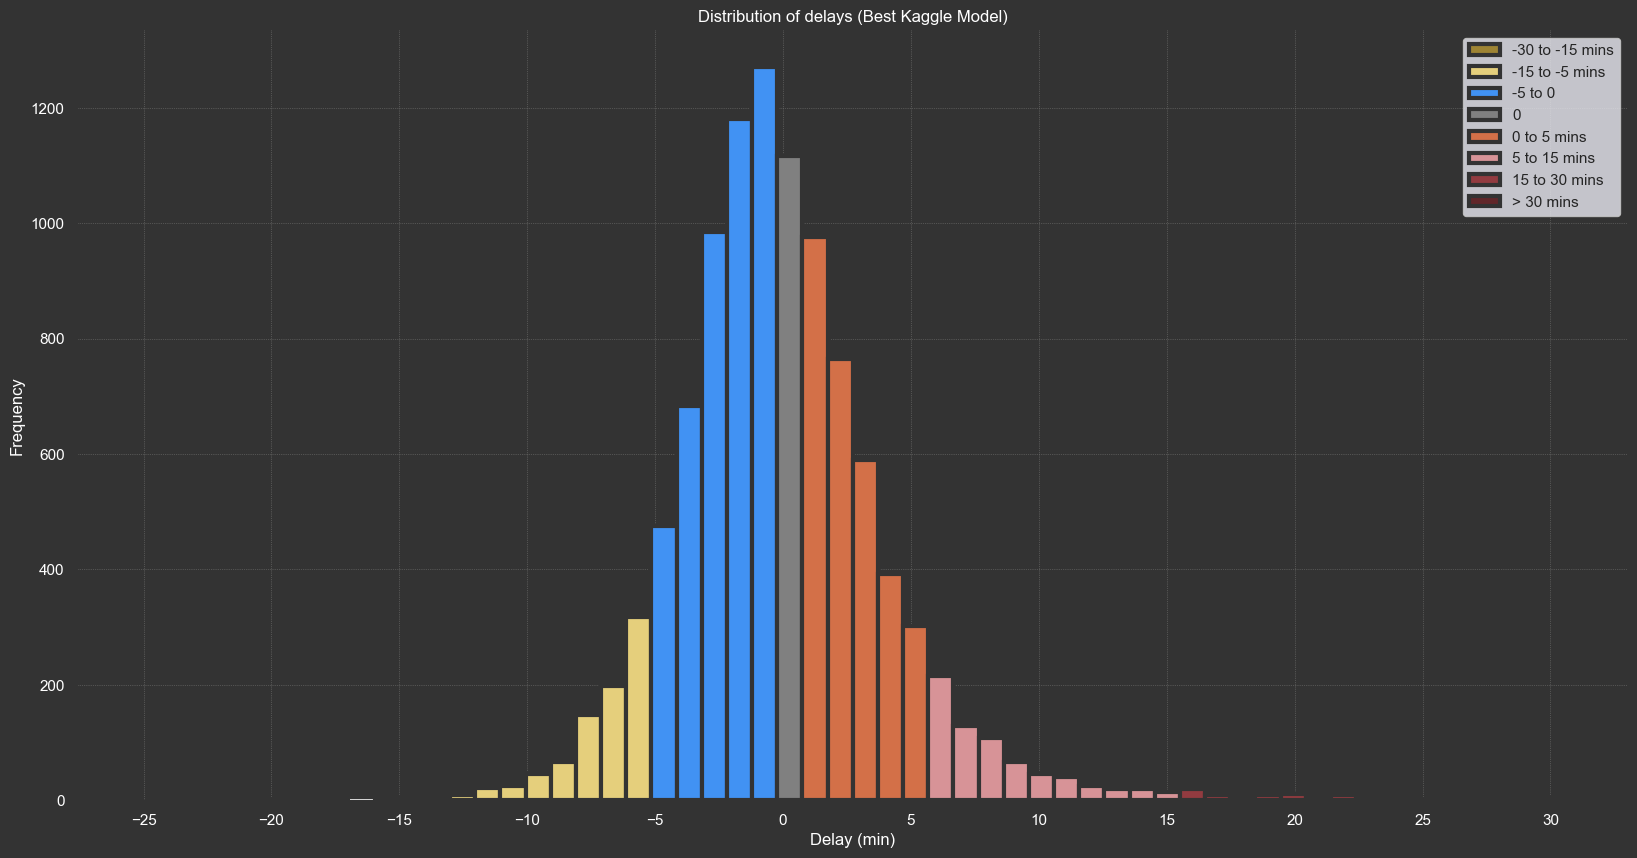

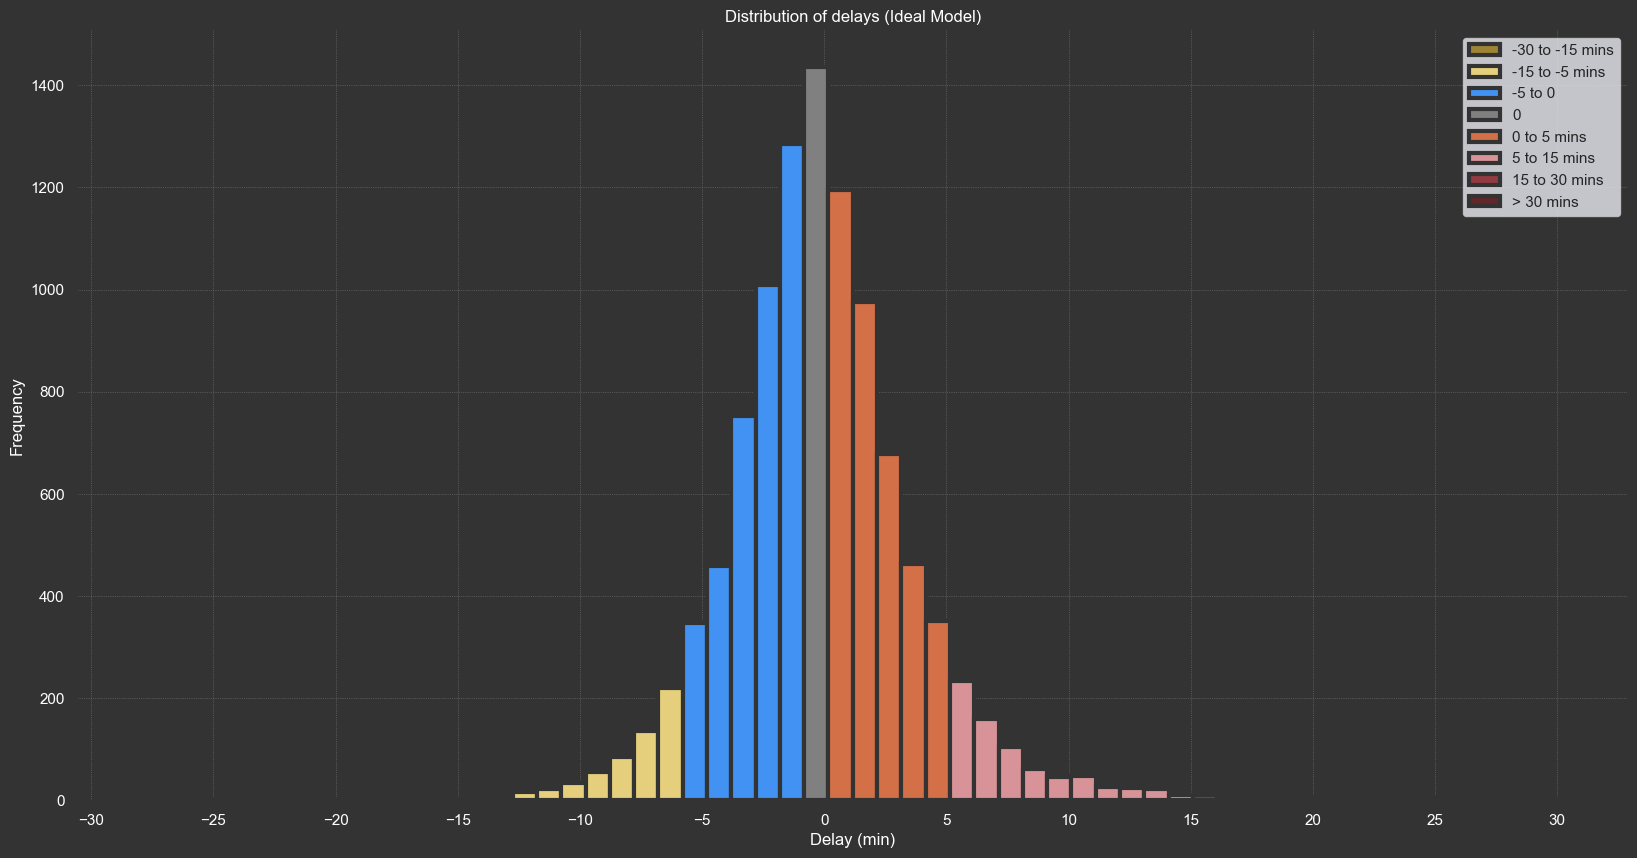

In [1805]:
delays_hist = y_test - y_pred
delays_hist = [delay / 60 for delay in delays_hist if -30 <= delay // 60 <= 30]
bins = int(max(delays_hist) - min(delays_hist) + 1)

conditions = [
    {'condition': '<= -30 mins', 'color': (0.416, 0.349, 0.122), 'range': (-float('inf'), -29)},
    {'condition': '-30 to -15 mins', 'color': (0.620, 0.518, 0.200), 'range': (-30, -16)},
    {'condition': '-15 to -5 mins', 'color': (0.898, 0.812, 0.486), 'range': (-16, -5)},  
    {'condition': '-5 to 0', 'color': (0.255, 0.573, 0.953), 'range': (-6, 0)},  
    {'condition': '0', 'color': (0.502, 0.502, 0.502), 'range': (-1, 1)},  
    {'condition': '0 to 5 mins', 'color': (0.827, 0.439, 0.282), 'range': (0, 6)},  
    {'condition': '5 to 15 mins', 'color': (0.843, 0.576, 0.592), 'range': (5, 16)},
    {'condition': '15 to 30 mins', 'color': (0.573, 0.231, 0.251), 'range': (15, 30)},
    {'condition': '> 30 mins', 'color': (0.380, 0.153, 0.165), 'range': (29, float('inf'))}  
]

fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor((51/255, 51/255, 51/255))
ax.set_title('Distribution of delays (Best Kaggle Model)', color='white')
ax.set_xlabel('Delay (min)', color='white')
ax.set_ylabel('Frequency', color='white')
ax.set_xticks(range(-200, 201, 5))

# Change the background color inside the axes
ax.set_facecolor((51/255, 51/255, 51/255))
ax.grid(True, linestyle='dotted', linewidth=0.5, color=(118/255, 118/255, 116/255))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Create a histogram with custom colors and no bin edges
n, bins, _ = ax.hist(delays_hist, bins=bins, color='lightgray', edgecolor='none')

used_labels = set()

# Adjust the colors based on conditions
for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    for condition in conditions:
        if condition['range'][0] <= start and condition['range'][1] >= end:
            if condition['condition'] not in used_labels:
                ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3, label=condition['condition'])
                used_labels.add(condition['condition'])
            else:
                ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3)
for text in ax.get_xticklabels() + ax.get_yticklabels():
    text.set_color('white')

ax.legend()
plt.show()

delays_hist = y_test - y_pred_ideal
delays_hist = [delay / 60 for delay in delays_hist if -30 <= delay // 60 <= 30]
bins = int(max(delays_hist) - min(delays_hist) + 1)

conditions = [
    {'condition': '<= -30 mins', 'color': (0.416, 0.349, 0.122), 'range': (-float('inf'), -29)},
    {'condition': '-30 to -15 mins', 'color': (0.620, 0.518, 0.200), 'range': (-30, -16)},
    {'condition': '-15 to -5 mins', 'color': (0.898, 0.812, 0.486), 'range': (-16, -5)},  
    {'condition': '-5 to 0', 'color': (0.255, 0.573, 0.953), 'range': (-6, 0)},  
    {'condition': '0', 'color': (0.502, 0.502, 0.502), 'range': (-1, 1)},  
    {'condition': '0 to 5 mins', 'color': (0.827, 0.439, 0.282), 'range': (0, 6)},  
    {'condition': '5 to 15 mins', 'color': (0.843, 0.576, 0.592), 'range': (5, 16)},
    {'condition': '15 to 30 mins', 'color': (0.573, 0.231, 0.251), 'range': (15, 30)},
    {'condition': '> 30 mins', 'color': (0.380, 0.153, 0.165), 'range': (29, float('inf'))}  
]

fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor((51/255, 51/255, 51/255))
ax.set_title('Distribution of delays (Ideal Model)', color='white')
ax.set_xlabel('Delay (min)', color='white')
ax.set_ylabel('Frequency', color='white')
ax.set_xticks(range(-200, 201, 5))

# Change the background color inside the axes
ax.set_facecolor((51/255, 51/255, 51/255))
ax.grid(True, linestyle='dotted', linewidth=0.5, color=(118/255, 118/255, 116/255))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Create a histogram with custom colors and no bin edges
n, bins, _ = ax.hist(delays_hist, bins=bins, color='lightgray', edgecolor='none')

used_labels = set()

# Adjust the colors based on conditions
for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    for condition in conditions:
        if condition['range'][0] <= start and condition['range'][1] >= end:
            if condition['condition'] not in used_labels:
                ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3, label=condition['condition'])
                used_labels.add(condition['condition'])
            else:
                ax.bar((start + end) / 2, n[i], width=end-start, color=condition['color'], edgecolor=(51/255, 51/255, 51/255), linewidth=3)
for text in ax.get_xticklabels() + ax.get_yticklabels():
    text.set_color('white')

ax.legend()
plt.show()



Current predictions

![ELDT ITA predictions](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F16677057%2F0d27208d107356e2ef0b16582b9c9799%2FUntitled.png?generation=1694384282991412&alt=media)

By comparing the two histograms above, being the first one the predictions made by the model created in this notebook and the second one being the ELDTs predicted in the year of 2022, it is possible to see that the model is able to predict the ELDTs with with an even better performance than the model that was used to predict the ELDTs in 2022. Although those are good results, it is important to emphasize that the model is making predictions based on a limited number of routes within the brazilian airspace, which means that the model could potentially perform worse if it was used to predict ELDTs for flights in other routes or even in other countries.

# Submission

In [1671]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)

In [1672]:
best_submission = pd.read_csv('data/submission_20346.csv')

In [1673]:
(best_submission == output).value_counts()

ID    solution
True  True        100
Name: count, dtype: int64